# IMU Coarse Calibration using Local Gravity Vector

Notebook to implement and test the *Inertial Navigation Unit* calibration framework presented by:
1. *D. Tedaldi, A. Pretto and E. Menegatti, "A robust and easy to implement method for IMU calibration without external equipments," 2014 IEEE International Conference on Robotics and Automation (ICRA), Hong Kong, China, 2014, pp. 3042-3049, doi: 10.1109/ICRA.2014.6907297.* 

In [1]:
import os
import numpy as np
import pandas as pd
import math

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = (14,6)

In [3]:
path_data = os.path.join('data/03CalibData.csv' )
headers = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

In [4]:
df = pd.read_csv(path_data, names=headers)
df.head()

,time,ax,ay,az,gx,gy,gz
0,1.676365e+09,-890,-456,16409,-121,126,-23
1,1.676365e+09,-890,-456,16452,-120,124,-28
2,1.676365e+09,-875,-439,16466,-117,123,-26
3,1.676365e+09,-848,-434,16472,-119,120,-27
4,1.676365e+09,-844,-447,16469,-121,118,-27


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    17698 non-null  float64
 1   ax      17698 non-null  int64  
 2   ay      17698 non-null  int64  
 3   az      17698 non-null  int64  
 4   gx      17698 non-null  int64  
 5   gy      17698 non-null  int64  
 6   gz      17698 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 968.0 KB


In [6]:
df['time'] = df['time'] - df['time'].loc[0]

In [7]:
# IMU data read through 16-bit signed A/D converter
IMU_MAX = 32767
IMU_MIN = -32768
IMU_RANGE = IMU_MAX - IMU_MIN

# Gyro reads in range +- 150 dps
GYRO_MIN = -250
GYRO_MAX = 250
GYRO_RANGE = GYRO_MAX - GYRO_MIN

# Pull from a local database next
GRAV_MAGNTD = 9.8066

# Accelorometer reads in +- 2g
ACCEL_MIN = -2 * GRAV_MAGNTD
ACCEL_MAX = 2 * GRAV_MAGNTD
ACCEL_RANGE = ACCEL_MAX - ACCEL_MIN

# Sensor Raw (bit) value to physical value
# val = (sensor_raw - IMU_MIN) / IMU_RANGE * sensor_range - sensor_max
for col in ['ax', 'ay', 'az']:
    df[col + '_ms2'] = (df[col] - IMU_MIN) / IMU_RANGE * ACCEL_RANGE + ACCEL_MIN

for col in ['gx', 'gy', 'gz']:
    df[col + '_dps'] = (df[col] - IMU_MIN) / IMU_RANGE * GYRO_RANGE + GYRO_MIN

df.head()

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps
0,0.000000,-890,-456,16409,-121,126,-23,-0.532416,-0.272642,9.822013,-0.919356,0.965133,-0.171664
1,0.009640,-890,-456,16452,-120,124,-28,-0.532416,-0.272642,9.847751,-0.911727,0.949874,-0.209812
2,0.019779,-875,-439,16466,-117,123,-26,-0.523438,-0.262467,9.856131,-0.888838,0.942245,-0.194553
3,0.029934,-848,-434,16472,-119,120,-27,-0.507277,-0.259474,9.859722,-0.904097,0.919356,-0.202182
4,0.040574,-844,-447,16469,-121,118,-27,-0.504882,-0.267255,9.857926,-0.919356,0.904097,-0.202182


In [8]:
def windowedVariance(arrAx, arrAy, arrAz, tw=2, fs=100):
    '''
    Calculates windowed variance centered at time 't' for the accelerometer dataset.

    Periods where local variance is high indicate a dynamic state, i.e. rotation, 
    and data in these periods are not used for accelerometer calibration.

    Periods where local variance is ~ 0 indicates a static state, where the IMU readings
    reflect 
    '''
    
    winLen = fs*tw                  # Data Point in Window
    halfWin = int(winLen/2)         # Half window for centered variance
    arrLen = arrAx.size
    
    arrAx = np.copy(arrAx)
    arrAy = np.copy(arrAy)
    arrAz = np.copy(arrAz)

    # Add head and tail to dataset (hold) for windowed methods
    arrAx = np.concatenate((arrAx[0] * np.ones(halfWin), arrAx, arrAx[-1] * np.ones(halfWin)))
    arrAy = np.concatenate((arrAy[0] * np.ones(halfWin), arrAy, arrAx[-1] * np.ones(halfWin)))
    arrAz = np.concatenate((arrAz[0] * np.ones(halfWin), arrAz, arrAy[-1] * np.ones(halfWin)))

    varArr = np.empty(arrLen)

    for i in range(halfWin, arrLen-halfWin):
        varArr[i] = math.sqrt(
                        math.pow(np.var(arrAx[i-halfWin:i+halfWin]),2) + \
                        math.pow(np.var(arrAy[i-halfWin:i+halfWin]),2) + \
                        math.pow(np.var(arrAz[i-halfWin:i+halfWin]),2)
        )
    
    return varArr

In [9]:
%timeit
windwdVarArr = windowedVariance(np.array(df['ax_ms2']), np.array(df['ay_ms2']), np.array(df['az_ms2']))

In [10]:
windwdVarArr

array([ 7.04366319e-312,  7.04399883e-312, -2.78029493e-001, ...,
        9.89683239e+000,  9.89503672e+000,  9.89503672e+000])

In [11]:
df['windwdVar'] = windwdVarArr
df.head()

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar
0,0.000000,-890,-456,16409,-121,126,-23,-0.532416,-0.272642,9.822013,-0.919356,0.965133,-0.171664,7.043663e-312
1,0.009640,-890,-456,16452,-120,124,-28,-0.532416,-0.272642,9.847751,-0.911727,0.949874,-0.209812,7.043999e-312
2,0.019779,-875,-439,16466,-117,123,-26,-0.523438,-0.262467,9.856131,-0.888838,0.942245,-0.194553,-2.780295e-01
3,0.029934,-848,-434,16472,-119,120,-27,-0.507277,-0.259474,9.859722,-0.904097,0.919356,-0.202182,-2.738396e-01
4,0.040574,-844,-447,16469,-121,118,-27,-0.504882,-0.267255,9.857926,-0.919356,0.904097,-0.202182,-2.750367e-01


In [12]:
df['windwdVar'] = df['windwdVar'].fillna(0)

(0.0, 0.1)

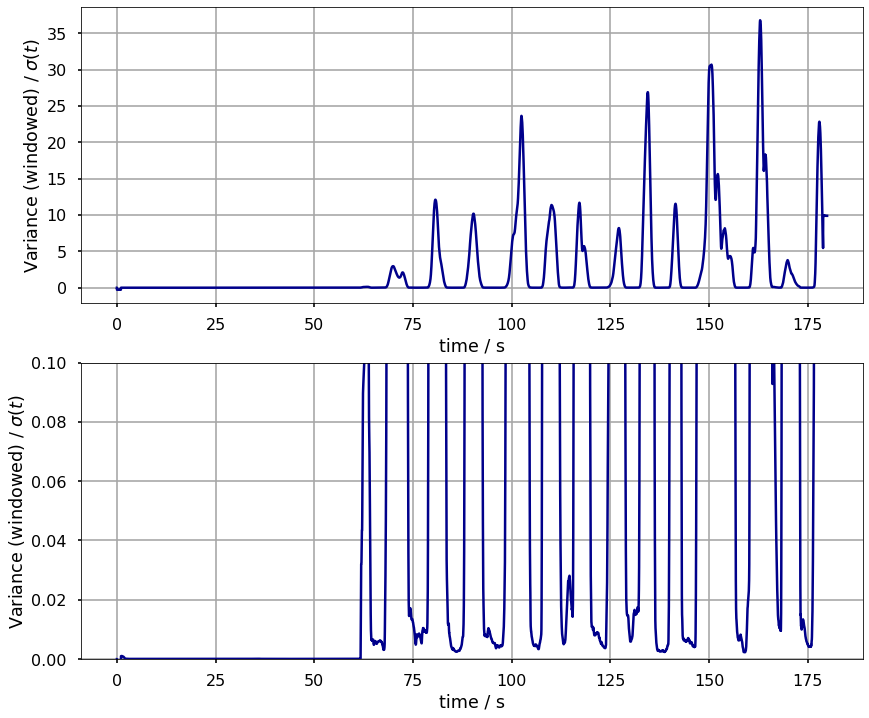

In [13]:
plt.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.plot(df['time'], windwdVarArr, color='darkblue', lineWidth=2.5)
plt.grid(True, which='both',ls='-',color='0.65')
plt.ylabel(r'Variance (windowed) / $\sigma(t)$')
plt.xlabel('time / s')

plt.subplot(2,1,2)
plt.plot(df['time'], windwdVarArr, color='darkblue', lineWidth=2.5)
plt.grid(True, which='both',ls='-',color='0.65')
plt.ylabel(r'Variance (windowed) / $\sigma(t)$')
plt.xlabel('time / s')
plt.ylim([0, 0.1])

From zoomed in figure above, if $\sigma(t) < 0.01$, assume state is at rest, else assume in motion.

In [14]:
restGroup = 0                           # Group continous rest states
zeroInbw = False
def classifyRestByVar(df, rowNum):
    if df['var']

In [15]:
df['inRest'] = df['windwdVar'].apply(lambda x: 1 if x < 0.1 else 0)

(-2.0, 25.0)

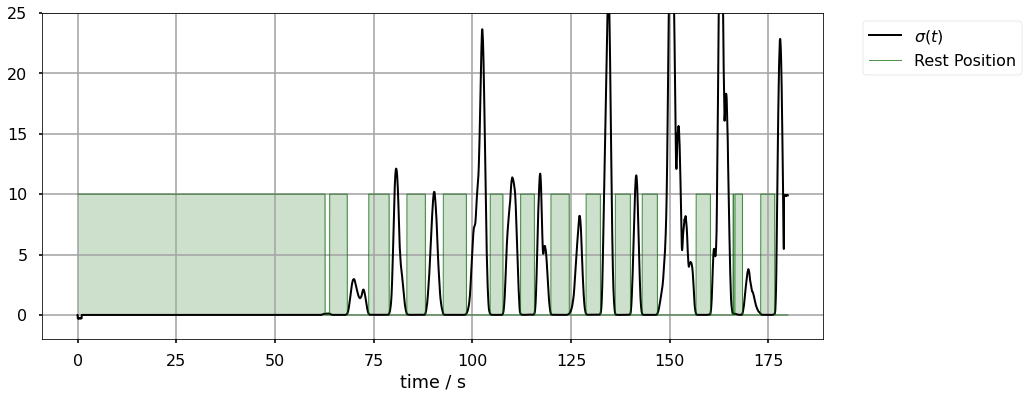

In [16]:
fig, ax = plt.subplots()

ax.plot(df['time'], windwdVarArr, color='k', lineWidth=2.0, label=r'$\sigma(t)$')
ax.plot(df['time'], 10 * df['inRest'], color='darkgreen', alpha=0.7, lineWidth=1, label='Rest Position')
ax.fill_between(df['time'], 0, 10 *df['inRest'], color='darkgreen', alpha=0.2)
ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.grid(True, which='both',ls='-',color='0.65')
plt.xlabel('time / s')
plt.ylim([-2, 25])

In [17]:
# Crop dataset to remove initial and final variance jumps
df_calb = df[(df['time'] > 50) & (df['time']<175)]

(-2.0, 25.0)

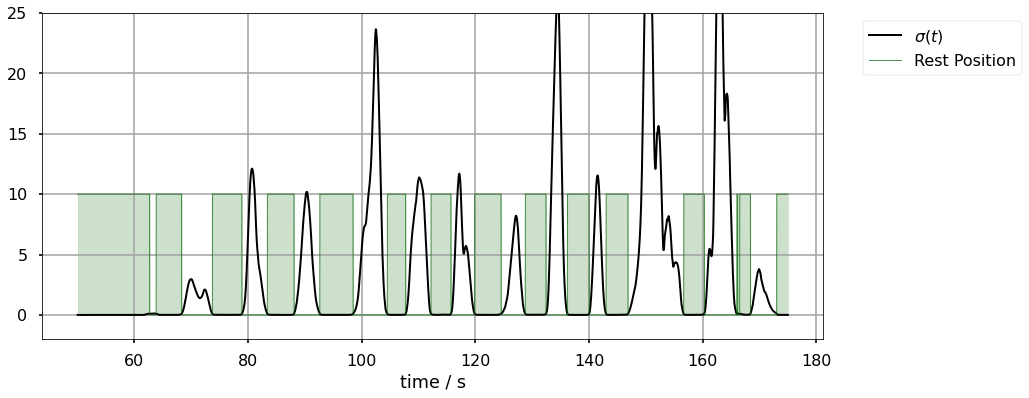

In [18]:
fig, ax = plt.subplots()

ax.plot(df_calb['time'], df_calb['windwdVar'], color='k', lineWidth=2.0, label=r'$\sigma(t)$')
ax.plot(df_calb['time'], 10 * df_calb['inRest'], color='darkgreen', alpha=0.7, lineWidth=1, label='Rest Position')
ax.fill_between(df_calb['time'], 0, 10 *df_calb['inRest'], color='darkgreen', alpha=0.2)
ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.grid(True, which='both',ls='-',color='0.65')
plt.xlabel('time / s')
plt.ylim([-2, 25])

From above, roughly 14 rest positions, need atleast 9 unique for 9 unkowns.
1. The rest accelerometer readings are seperated from one another, then each group is average (elimated noise in sensor model)
2. The average vector from each group is added to an aggregate accelerometer matrix.
3. This matrix fed to cost function for least square minimization

In [19]:
from scipy.optimize import least_squares

In [20]:
def L_ThetaAcc(accMat:np.ndarray, Ta:np.ndarray, Ka:np.ndarray, ba:np.ndarray):
    '''
    accMat 3xN matrix of accelerometer readings 
    '''
    residl = 0                          # Residual
    numColumns = accMat.shape[1]        # N
    for i in range(numColumns):
        residl += math.sqrt(
                        math.pow(GRAV_MAGNTD, 2) + \
                        np.linalg.norm(
                            np.matmul(
                            np.matmul(Ta, Ka),
                            accMat[:,i] + ba 
                            )
                        )
                    )
    return residl